In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('Data/train_data_new.csv', usecols=['file', 'sample','ENC_POS_FLOATMAG_BH', 'dENC_X', 'ddENC_X', 'FLOATMAG_ACC_ADC_PORT_0', 'DAC_FLOATMAG_BH']).dropna()
test = pd.read_csv('Data/test_data_new.csv', usecols=['file', 'sample','ENC_POS_FLOATMAG_BH', 'dENC_X', 'ddENC_X', 'FLOATMAG_ACC_ADC_PORT_0', 'DAC_FLOATMAG_BH']).dropna()
# train = pd.read_csv('Data/train_data_new.csv', usecols=['file', 'sample','ENC_POS_FLOATMAG_BH', 'dENC_X', 'ddENC_X', 'FLOATMAG_ACC_ADC_PORT_0', 'DAC_FLOATMAG_BH'])
# test = pd.read_csv('Data/test_data_new.csv', usecols=['file', 'sample','ENC_POS_FLOATMAG_BH', 'dENC_X', 'ddENC_X', 'FLOATMAG_ACC_ADC_PORT_0', 'DAC_FLOATMAG_BH'])

train, test

(        sample  ENC_POS_FLOATMAG_BH  dENC_X  ddENC_X  FLOATMAG_ACC_ADC_PORT_0  \
 2            2                  1.0     0.0     -3.0                    114.0   
 3            3                  2.0     1.0      1.0                    -76.0   
 4            4                  2.0     0.0     -1.0                     49.0   
 5            5                  0.0    -2.0     -2.0                    -10.0   
 6            6                 -1.0    -1.0      1.0                     41.0   
 ...        ...                  ...     ...      ...                      ...   
 210217    3873             100001.0     0.0     -2.0                    243.0   
 210218    3874             100000.0    -1.0     -1.0                     46.0   
 210219    3875             100004.0     4.0      5.0                     85.0   
 210220    3876             100000.0    -4.0     -8.0                    -26.0   
 210221    3877             100001.0     1.0      5.0                    -64.0   
 
         DAC_F

In [3]:
len(train), len(test)

(210174, 15634)

In [4]:

def build_training_set(data, sequence_length, prediction_timestep):

    #input data will just be matrix of values, timestep x (features + target)

    #output will be matrix: (data_trial x timestep x features) and (data_trial x target)

    #ok so we will have a trial for every data point, (because rolling window)
    #for timesteps that dont have he full sequence length, we will just pad with zeros
    #will remove nan values later

    #first lets pad the data with zeros (need sequence_length - 1 zeros)

    shape = data.shape

    num_features = shape[1] - 1 #subtract 1 for target

    zero_padding_features = np.zeros((sequence_length - 1, num_features))
    nan_padding_target = np.full((sequence_length - 1, 1), np.nan)
    to_pad_with = np.hstack((zero_padding_features, nan_padding_target))

    data = np.vstack((to_pad_with, data))


    #now lets build the training set

    X = []
    y = []

    for indx, i in enumerate(range(shape[0] - prediction_timestep)): #one trial for every data point except the last one (or however many we are predicting ahead)

        trial = data[i:i+sequence_length, :]

        #check for nan values
        if np.isnan(trial[:,:-1]).any() or np.isnan(trial[-1,-1]).any():
            continue

        X.append(trial[:,:-1])
        y.append([trial[-1,-1]])

    X = np.array(X)
    y = np.array(y)


    return X, y


    

In [5]:
sequence_length = 10
prediction_timestep = 1

train["target"] = train.groupby("file")["FLOATMAG_ACC_ADC_PORT_0"].shift(-prediction_timestep)

X, y = [], []

for file_num in train["file"].unique():

    data = train[train["file"] == file_num][["ENC_POS_FLOATMAG_BH", "dENC_X", "ddENC_X", "DAC_FLOATMAG_BH", "target"]].values

    X_temp, y_temp = build_training_set(data, sequence_length, prediction_timestep)

    X.extend(X_temp)
    y.extend(y_temp)

X = np.array(X)
y = np.array(y)


test["target"] = test.groupby("file")["FLOATMAG_ACC_ADC_PORT_0"].shift(-prediction_timestep)
X_test, y_test = [], []

for file_num in test["file"].unique():

    data = test[test["file"] == file_num][["ENC_POS_FLOATMAG_BH", "dENC_X", "ddENC_X", "DAC_FLOATMAG_BH", "target"]].values

    X_temp, y_temp = build_training_set(data, sequence_length, prediction_timestep)

    X_test.extend(X_temp)
    y_test.extend(y_temp)

X_test = np.array(X_test)
y_test = np.array(y_test)




In [6]:
X.shape, y.shape

((210150, 10, 4), (210150, 1))

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Normalization

mae = tf.keras.metrics.mean_absolute_error

2023-11-06 02:08:50.950342: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 02:08:51.084643: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 02:08:51.084771: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 02:08:51.085284: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-06 02:08:51.164567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 02:08:51.165976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [8]:

input_norm = Normalization(axis=1)

input_norm.adapt(X)

2023-11-06 02:08:53.455392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 02:08:53.455736: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
output_norm = Normalization(axis=1)

output_norm.adapt(y)

In [22]:
model = Sequential([
    Input(shape=(sequence_length, 4)),  # Input shape: 10 timesteps with 4 features each
    input_norm,
    LSTM(250),  # LSTM layer with 50 units
    Dense(50),
    Dense(1)  # Output layer with 1 unit
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [11]:
y.shape

(210150, 1)

In [12]:
greater_than_0_indexes = np.where(y > 0)[0]
less_than_0_indexes = np.where(y < 0)[0]

y_greater_than_0 = y[greater_than_0_indexes]
X_greater_than_0 = X[greater_than_0_indexes]

y_less_than_0 = y[less_than_0_indexes]
X_less_than_0 = X[less_than_0_indexes]
mae_values = []
val_mae_values = []

for epoch in range(10):
    print(f"epoch: {epoch}")

    #just y greater than 0:
    history = model.fit(X_greater_than_0, output_norm(y_greater_than_0), epochs=1, batch_size=32, validation_data = (X_test, output_norm(y_test)))

    #just y less than 0:
    history = model.fit(X_less_than_0, output_norm(y_less_than_0), epochs=1, batch_size=32, validation_data = (X_test, output_norm(y_test)))

In [23]:
history = model.fit(X, output_norm(y), epochs=10, batch_size=32, validation_data = (X_test, output_norm(y_test)))

Epoch 1/10
6568/6568 [==============================] - 107s 16ms/step - loss: 0.7472 - mae: 0.4064 - val_loss: 0.8672 - val_mae: 0.5471
Epoch 2/10
6568/6568 [==============================] - 105s 16ms/step - loss: 0.5517 - mae: 0.3801 - val_loss: 1.0957 - val_mae: 0.6210
Epoch 3/10
6568/6568 [==============================] - 112s 17ms/step - loss: 0.4213 - mae: 0.3495 - val_loss: 0.4944 - val_mae: 0.4599
Epoch 4/10
6568/6568 [==============================] - 112s 17ms/step - loss: 0.3676 - mae: 0.3201 - val_loss: 0.4366 - val_mae: 0.4440
Epoch 5/10
6568/6568 [==============================] - 110s 17ms/step - loss: 0.3512 - mae: 0.3118 - val_loss: 0.4703 - val_mae: 0.4653
Epoch 6/10
6568/6568 [==============================] - 103s 16ms/step - loss: 0.3598 - mae: 0.3165 - val_loss: 0.4427 - val_mae: 0.4527
Epoch 7/10
6568/6568 [==============================] - 105s 16ms/step - loss: 0.3343 - mae: 0.3038 - val_loss: 0.4472 - val_mae: 0.4381
Epoch 8/10
6568/6568 [===================

In [29]:
#without output normalization
history = model.fit(X, y, epochs=10, batch_size=32, validation_data = (X_test, y_test))

Epoch 1/10
6568/6568 [==============================] - 39s 6ms/step - loss: 4211520.0000 - mae: 858.6107 - val_loss: 8372781.5000 - val_mae: 1571.0773
Epoch 2/10
6568/6568 [==============================] - 41s 6ms/step - loss: 4165157.5000 - mae: 899.8870 - val_loss: 8274469.0000 - val_mae: 1576.6472
Epoch 3/10
6568/6568 [==============================] - 39s 6ms/step - loss: 4131575.5000 - mae: 896.2947 - val_loss: 8185651.5000 - val_mae: 1584.4233
Epoch 4/10
6568/6568 [==============================] - 39s 6ms/step - loss: 4077713.0000 - mae: 898.4851 - val_loss: 8122134.5000 - val_mae: 1582.1575
Epoch 5/10
6568/6568 [==============================] - 39s 6ms/step - loss: 4048593.2500 - mae: 902.5491 - val_loss: 7817765.5000 - val_mae: 1519.3124
Epoch 6/10
6568/6568 [==============================] - 39s 6ms/step - loss: 3978857.7500 - mae: 880.9604 - val_loss: 7795712.5000 - val_mae: 1525.5582
Epoch 7/10
6568/6568 [==============================] - 39s 6ms/step - loss: 3940207.750

In [30]:
# Continue training for more epochs if needed
additional_epochs = 20
history = model.fit(X, y, initial_epoch=10, epochs=10+additional_epochs, batch_size=32, validation_data=(X_test, y_test))


Epoch 11/30
6568/6568 [==============================] - 39s 6ms/step - loss: 3596123.2500 - mae: 816.3729 - val_loss: 7117176.5000 - val_mae: 1477.6595
Epoch 12/30
6568/6568 [==============================] - 39s 6ms/step - loss: 3554743.5000 - mae: 846.9171 - val_loss: 6994578.5000 - val_mae: 1475.4437
Epoch 13/30
6568/6568 [==============================] - 38s 6ms/step - loss: 3510800.2500 - mae: 846.7580 - val_loss: 6515819.0000 - val_mae: 1432.3711
Epoch 14/30
6568/6568 [==============================] - 39s 6ms/step - loss: 3481429.7500 - mae: 855.0689 - val_loss: 6447980.5000 - val_mae: 1440.6399
Epoch 15/30
6568/6568 [==============================] - 39s 6ms/step - loss: 3402275.7500 - mae: 828.9791 - val_loss: 6108018.0000 - val_mae: 1418.8984
Epoch 16/30
6568/6568 [==============================] - 39s 6ms/step - loss: 3297330.7500 - mae: 803.6953 - val_loss: 6078488.0000 - val_mae: 1402.1577
Epoch 17/30
6568/6568 [==============================] - 42s 6ms/step - loss: 3217

In [43]:
# Continue training for more epochs if needed
additional_epochs = 5
history = model.fit(X, y, initial_epoch=30, epochs=30+additional_epochs, batch_size=32, validation_data=(X_test, y_test))

Epoch 31/35
6568/6568 [==============================] - 38s 6ms/step - loss: 2148131.0000 - mae: 689.7484 - val_loss: 4320355.0000 - val_mae: 1253.2371
Epoch 32/35
6568/6568 [==============================] - 38s 6ms/step - loss: 2135857.0000 - mae: 692.8284 - val_loss: 3521385.7500 - val_mae: 1171.6370
Epoch 33/35
6568/6568 [==============================] - 43s 7ms/step - loss: 2104129.2500 - mae: 681.8383 - val_loss: 3910284.5000 - val_mae: 1222.3813
Epoch 34/35
6568/6568 [==============================] - 42s 6ms/step - loss: 2152541.0000 - mae: 708.9694 - val_loss: 3418999.5000 - val_mae: 1172.5015
Epoch 35/35
6568/6568 [==============================] - 43s 7ms/step - loss: 2131829.5000 - mae: 712.8134 - val_loss: 3389422.0000 - val_mae: 1150.6195


In [45]:
additional_epochs = 30
history = model.fit(X, y, initial_epoch=35, epochs=35+additional_epochs, batch_size=32, validation_data=(X_test, y_test))

Epoch 36/65
6568/6568 [==============================] - 40s 6ms/step - loss: 1883576.8750 - mae: 659.1358 - val_loss: 3376663.2500 - val_mae: 1162.4619
Epoch 37/65
6568/6568 [==============================] - 42s 6ms/step - loss: 1954402.5000 - mae: 667.3718 - val_loss: 3303159.7500 - val_mae: 1149.3469
Epoch 38/65
6568/6568 [==============================] - 44s 7ms/step - loss: 1745728.8750 - mae: 639.9955 - val_loss: 3042082.2500 - val_mae: 1111.6483
Epoch 39/65
6568/6568 [==============================] - 44s 7ms/step - loss: 1744026.3750 - mae: 639.0919 - val_loss: 2759889.7500 - val_mae: 1074.8674
Epoch 40/65
6568/6568 [==============================] - 44s 7ms/step - loss: 1736680.7500 - mae: 638.1533 - val_loss: 3244528.0000 - val_mae: 1140.0321
Epoch 41/65
6568/6568 [==============================] - 44s 7ms/step - loss: 1597614.2500 - mae: 619.5392 - val_loss: 3771926.0000 - val_mae: 1189.3700
Epoch 42/65
6568/6568 [==============================] - 43s 7ms/step - loss: 1646

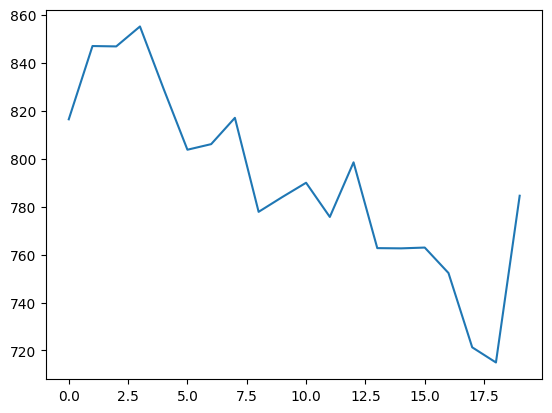

In [33]:

plt.plot(history.history["mae"])

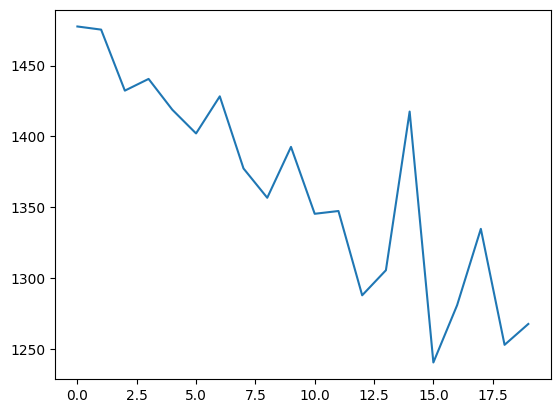

In [32]:

plt.plot(history.history["val_mae"])

In [15]:
one_trial_test = test[test["file"] == 24][["ENC_POS_FLOATMAG_BH", "dENC_X", "ddENC_X", "DAC_FLOATMAG_BH", "target"]].values


In [16]:

X_test_one_trial, y_test_one_trial = build_training_set(one_trial_test, sequence_length, prediction_timestep)



In [17]:
X_test_one_trial.shape, y_test_one_trial.shape

((3627, 10, 4), (3627, 1))

114/114 [==============================] - 0s 3ms/step


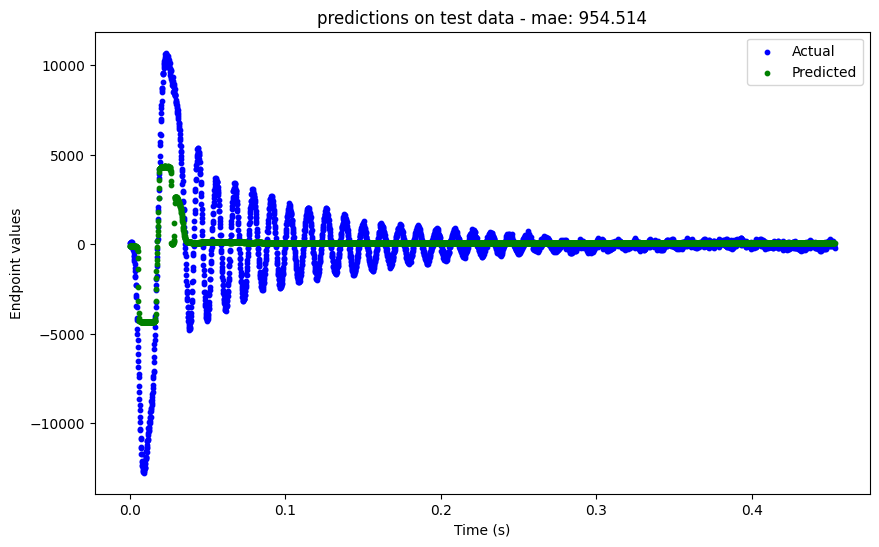

In [41]:
#now we need to use the model to predict on one file from the test data, to actually vizualize the predictions


times = np.array(range(len(X_test_one_trial))) / 8000

predictions_one_trial = model.predict(X_test_one_trial)
# rmse_test = np.sqrt(mse(y_test_one_trial.flatten(), predictions_one_trial.flatten()))
mae_test = mae(y_test_one_trial.flatten(), predictions_one_trial.flatten())

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(times, y_test_one_trial.flatten(), color='blue', label='Actual', s = 10)
plt.scatter(times, predictions_one_trial.flatten(), color='green', label='Predicted', s=10)


# plt.title(f'predictions on test data - RMSE: {rmse_test:.3f}')
plt.title(f'predictions on test data - mae: {mae_test:.3f}')

plt.xlabel('Time (s)')
plt.ylabel('Endpoint values')
plt.legend()
plt.show()

114/114 [==============================] - 0s 2ms/step


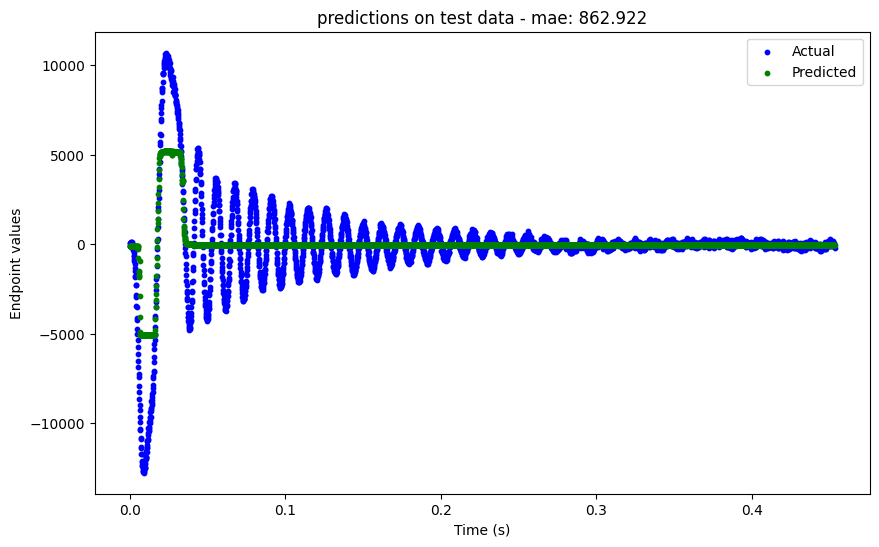

In [44]:

times = np.array(range(len(X_test_one_trial))) / 8000

predictions_one_trial = model.predict(X_test_one_trial)
# rmse_test = np.sqrt(mse(y_test_one_trial.flatten(), predictions_one_trial.flatten()))
mae_test = mae(y_test_one_trial.flatten(), predictions_one_trial.flatten())

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(times, y_test_one_trial.flatten(), color='blue', label='Actual', s = 10)
plt.scatter(times, predictions_one_trial.flatten(), color='green', label='Predicted', s=10)


# plt.title(f'predictions on test data - RMSE: {rmse_test:.3f}')
plt.title(f'predictions on test data - mae: {mae_test:.3f}')

plt.xlabel('Time (s)')
plt.ylabel('Endpoint values')
plt.legend()
plt.show()

114/114 [==============================] - 0s 2ms/step


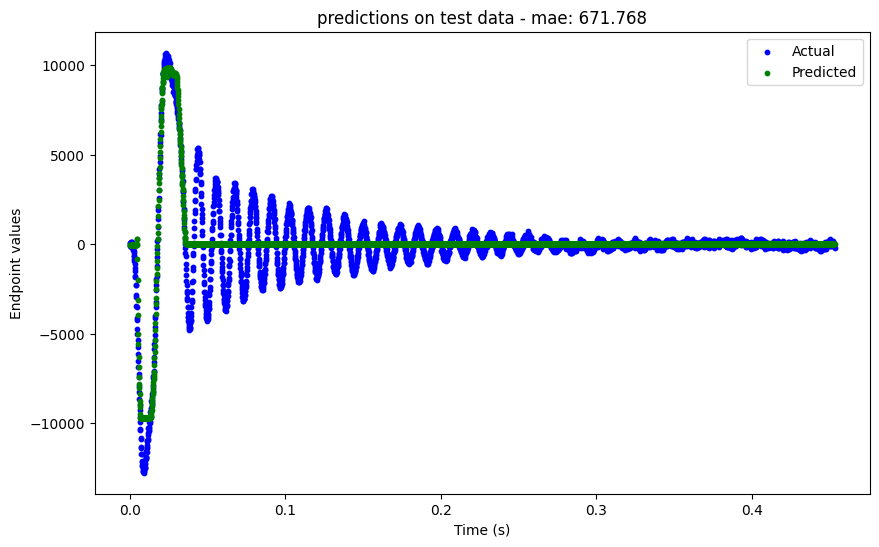

In [46]:
times = np.array(range(len(X_test_one_trial))) / 8000

predictions_one_trial = model.predict(X_test_one_trial)
# rmse_test = np.sqrt(mse(y_test_one_trial.flatten(), predictions_one_trial.flatten()))
mae_test = mae(y_test_one_trial.flatten(), predictions_one_trial.flatten())

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(times, y_test_one_trial.flatten(), color='blue', label='Actual', s = 10)
plt.scatter(times, predictions_one_trial.flatten(), color='green', label='Predicted', s=10)


# plt.title(f'predictions on test data - RMSE: {rmse_test:.3f}')
plt.title(f'predictions on test data - mae: {mae_test:.3f}')

plt.xlabel('Time (s)')
plt.ylabel('Endpoint values')
plt.legend()
plt.show()

In [18]:
inverse_output_norm = Normalization(axis=1, invert=True)

inverse_output_norm.adapt(y)

114/114 [==============================] - 1s 6ms/step


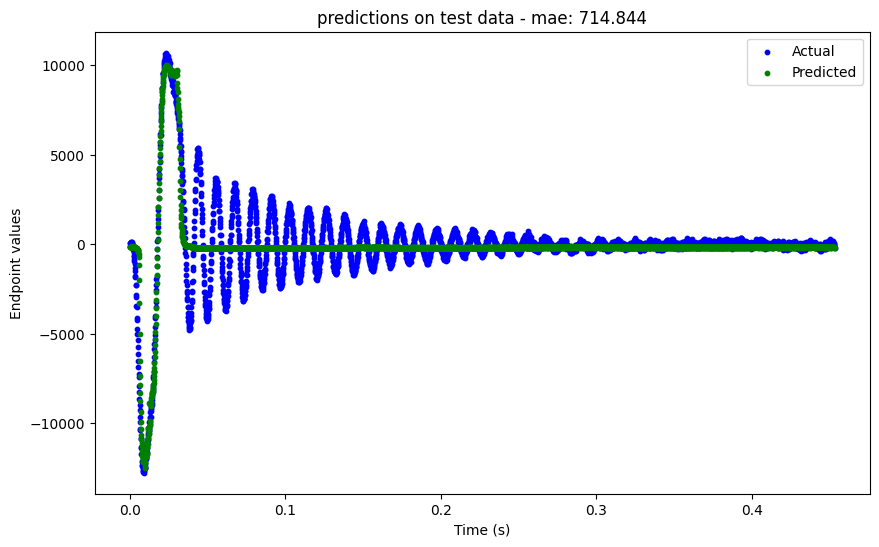

In [24]:
#with output normalization

times = np.array(range(len(X_test_one_trial))) / 8000

predictions_one_trial = model.predict(X_test_one_trial)
# rmse_test = np.sqrt(mse(y_test_one_trial.flatten(), predictions_one_trial.flatten()))
mae_test = mae(y_test_one_trial.flatten(), inverse_output_norm(predictions_one_trial).numpy().flatten())

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(times, y_test_one_trial.flatten(), color='blue', label='Actual', s = 10)
plt.scatter(times, inverse_output_norm(predictions_one_trial).numpy(), color='green', label='Predicted', s=10)


# plt.title(f'predictions on test data - RMSE: {rmse_test:.3f}')
plt.title(f'predictions on test data - mae: {mae_test:.3f}')

plt.xlabel('Time (s)')
plt.ylabel('Endpoint values')
plt.legend()
plt.show()

In [66]:
predictions_one_trial[:100]

array([[-2.36485329e+01],
       [ 9.28385735e+00],
       [ 6.03774109e+01],
       [-5.75944901e+01],
       [-2.97165470e+01],
       [ 7.72376251e+01],
       [ 1.10912636e+02],
       [-5.13926430e+01],
       [-6.54404449e+01],
       [-2.25384541e+01],
       [-1.52613163e+01],
       [-7.74827003e-02],
       [-2.16082401e+01],
       [-1.15602768e+02],
       [-1.01880516e+02],
       [-1.64457733e+02],
       [-2.16675201e+02],
       [-2.27859024e+02],
       [-2.25357651e+02],
       [-2.25610809e+02],
       [-2.19130173e+02],
       [-2.18329697e+02],
       [-2.18423401e+02],
       [-2.18473892e+02],
       [-2.18491241e+02],
       [-2.18493683e+02],
       [-2.18504410e+02],
       [-2.18059845e+02],
       [-2.14903091e+02],
       [-2.11800430e+02],
       [-1.71641235e+02],
       [-1.66951950e+02],
       [-1.69205292e+02],
       [-1.69050888e+02],
       [-1.69249542e+02],
       [-1.69249542e+02],
       [-1.69249542e+02],
       [-1.69249542e+02],
       [-1.6